In [1]:
#%matplotlib notebook
import time, winsound, h5py, os
import numpy as np
import matplotlib.pyplot as plt
from lcls_beamline_toolbox.xraybeamline2d import beam1d as beam, optics1d as optics, beamline1d as beamline

%load_ext autoreload
%autoreload 2
from Functions import *
from Prism import *

In [2]:
N = 128       # number of sampling points
E0 = 9.5e3    # photon energy in eV
z_off=.12     # distance offset between VCC crystal 1 and CC crystal 1
d23=.2        # distance between VCC crystal 2 and 3
FOV1 = 2e-3   # [m]
FOV2 = 500e-6 # [m]

tau = 3
window = 1500

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
    'photonEnergy': E0,
    'N': N,
    'sigma_x': 50e-6/(2*np.sqrt(2*np.log(2))),
    'sigma_y': 50e-6/(2*np.sqrt(2*np.log(2))),
    'rangeFactor': 5,
    'scaleFactor': 10,
    'z_source': 0
}

-5.000000000065104e-05


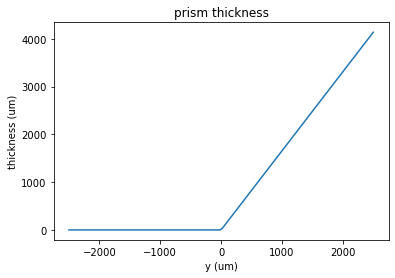

In [3]:
''' prism '''
# parameters
f_prism = 8.         # [m]
overlap = 50e-6      # [m]
x_prism = 5e-3       # [m]
y_prism = 5e-3       # [m]
dx_prism = 0         # [m]
dy_prism = y_prism/2 # [m]
material = 'Be'
orientation = 1      # defined as 0: thicker to +x; 1: thicker to +y; 2: thicker to -x; 3: thicker to -y

cxro_data = np.genfromtxt('{}.csv'.format(material), delimiter=',')
prism_energy = cxro_data[:, 0]
prism_delta = cxro_data[:, 1]
prism_beta = cxro_data[:, 2]

delta = np.interp(beam_params['photonEnergy'], prism_energy, prism_delta)
beta = np.interp(beam_params['photonEnergy'], prism_energy, prism_beta)
slope = np.tan(np.pi/2 - np.arctan(f_prism*delta/overlap))

# plot prism
yy = np.linspace(-y_prism/2,y_prism/2,N)

aperture = (np.abs(yy - dy_prism) < y_prism / 2).astype(float)
thickness = slope*(yy - dy_prism + y_prism/2)
p1_y = -delta * slope

plt.plot(yy*1e6,thickness*aperture*1e6)
plt.title('prism thickness')
plt.xlabel('y (um)')
plt.ylabel('thickness (um)')
print(np.tan(p1_y)*f_prism)

In [4]:
''' define beamline '''
def define_branch_VCC(E0=9000, z_off=.12, d23=.2, alphaAsym=np.deg2rad(5), FOV1 = 1e-3, FOV2 = 100e-6, N = 1024):
    # crystal reflection hkl index
    hkl = [2,2,0]

    # viewing point upstream of monochromator
    im0 = optics.PPM('im0', z=400-.01, FOV=FOV1, N=N)

    slit = optics.Slit('s0', x_width=1., y_width=100e-3, dx=0, dy=-50e-3, z=400)
    
    # first crystal: symmetric reflection
    crystal1 = optics.Crystal('c1', hkl=hkl, length=10e-2, width=20e-3, z=400+z_off, E0=E0,
                              alphaAsym=0, orientation=1, pol='s', delta=0.e-6)
    
    # second crystal: asymmetric reflection, orientation flipped relative to crystal 1
    z12 = np.cos(2*crystal1.beta0)*0.02
    crystal2 = optics.Crystal('c2', hkl=hkl, length=10e-2, width=20e-3, z=crystal1.z+z12, E0=E0,
                              alphaAsym=alphaAsym, orientation=3, pol='s', delta=0.e-6)
    
    # printing crystal incidence and reflection angles for confirmation
    print('crystal 2 incidence angle: {:.2f} degrees'.format(crystal2.alpha*180/np.pi))
    print('crystal 2 exit angle: {:.2f} degrees'.format(crystal2.beta0*180/np.pi))

    im1 = optics.PPM('im1', z=crystal2.z+d23/2, FOV=FOV1, N=N)

    # third crystal, symmetric reflection, same orientation as crystal2
    z23 = d23
    crystal3 = optics.Crystal('c3', hkl=hkl, length=10e-2, width=10e-3, z=crystal2.z+z23, E0=E0,
                              alphaAsym=0, orientation=3, pol='s', asym_type='emergence')

    # fourth crystal, asymmetric reflection, same orientation as crystal1
    z34 = z12
    crystal4 = optics.Crystal('c4', hkl=hkl, length=10e-2, width=10e-3, z=crystal3.z+z34, E0=E0,
                              alphaAsym=alphaAsym, orientation=1, pol='s', asym_type='emergence')

    # viewing point just downstream of monochromator
    im2 = optics.PPM('im2', z=crystal4.z+z_off+.01, FOV=FOV1, N=N)
    
    # viewing point at crossing
    im3 = optics.PPM('im3', z=im2.z+f_prism+.01, FOV=FOV2, N=N)

    # list of devices to propagate through
    devices = [im0, slit, crystal1, crystal2, im1, crystal3, crystal4, im2, im3]

    return devices

def define_branch_CC(E0=9000, d23 = .2, alphaAsym=np.deg2rad(0), FOV1 = 1e-3, FOV2 = 100e-6, N = 1024):
    # crystal reflection hkl index
    hkl = [2,2,0]

    # viewing point upstream of monochromator
    im0 = optics.PPM('im0', z=400-.01, FOV = FOV1, N=N)
    
    slit = optics.Slit('s0', x_width=1., y_width=100e-3, dx=0, dy=50e-3, z=400)

    # first crystal: symmetric reflection
    crystal1 = optics.Crystal('c1', hkl=hkl, length=10e-2, width=20e-3, z=400, E0=E0,
                              alphaAsym=0, orientation=3, pol='s', delta=0.e-6)
    
    # second crystal: symmetric reflection, orientation flipped relative to crystal 1
    z12 = np.cos(2*crystal1.beta0)*0.02
    crystal2 = optics.Crystal('c2', hkl=hkl, length=10e-2, width=20e-3, z=crystal1.z+z12, E0=E0,
                              alphaAsym=0, orientation=1, pol='s', delta=0.e-6)
    
    # printing crystal incidence and reflection angles for confirmation
    print('crystal 2 incidence angle: {:.2f} degrees'.format(crystal2.alpha*180/np.pi))
    print('crystal 2 exit angle: {:.2f} degrees'.format(crystal2.beta0*180/np.pi))

    im1 = optics.PPM('im1', z=crystal2.z+d23/2+z_off, FOV=FOV1, N=N)

    # third crystal, symmetric reflection, same orientation as crystal2
    z23 = d23 + 2*z_off
    crystal3 = optics.Crystal('c3', hkl=hkl, length=10e-2, width=10e-3, z=crystal2.z+z23, E0=E0,
                              alphaAsym=0, orientation=1, pol='s', asym_type='emergence')

    # fourth crystal, symmetric reflection, same orientation as crystal1
    z34 = z12
    crystal4 = optics.Crystal('c4', hkl=hkl, length=10e-2, width=10e-3, z=crystal3.z+z34, E0=E0,
                              alphaAsym=0, orientation=3, pol='s', asym_type='emergence')
    
    # viewing point just downstream of monochromator
    im2 = optics.PPM('im2', z=crystal4.z+.01, FOV=FOV1, N=N)
    
    # prism
    prism = Prism('prism', x_width=x_prism, y_width=y_prism, slope=slope, material='Be', z=im2.z+.01,
                  dx=dx_prism, dy=dy_prism, orientation=1)
    
    # viewing point at crossing
    im3 = optics.PPM('im3', z=im2.z+f_prism+.01, FOV=FOV2, N=N)
    
    # list of devices to propagate through
    devices = [im0, slit, crystal1, crystal2, im1, crystal3, crystal4, im2, prism, im3]

    return devices


In [5]:
# initialize optical elements
devices_VCC = define_branch_VCC(E0=E0, z_off=z_off, d23=d23, FOV1=FOV1, FOV2=FOV2, N=N)
branch_VCC = beamline.Beamline(devices_VCC)
for oe in devices_VCC:
    if oe.name == 'c4':
        print('VCC crystal 4 incidence angle: {:.2f} degrees'.format(oe.alpha*180/np.pi))
        print('VCC crystal 4 exit angle: {:.2f} degrees\n\n\n'.format(oe.beta0*180/np.pi))
        
devices_CC = define_branch_CC(E0=E0, d23=d23, FOV1=FOV1, FOV2=FOV2, N=N)
branch_CC = beamline.Beamline(devices_CC)
for oe in devices_CC:
    if oe.name == 'c4':
        print('CC crystal 4 incidence angle: {:.2f} degrees'.format(oe.alpha*180/np.pi))
        print('CC crystal 4 exit angle: {:.2f} degrees\n\n\n'.format(oe.beta0*180/np.pi))


b 1.00
b 1.64
crystal 2 incidence angle: 24.87 degrees
crystal 2 exit angle: 14.87 degrees
b 1.00
b 1.64
after c1: 0.6936
after c2: -0.0000
after c3: -0.6936
after c4: 0.0000
VCC crystal 4 incidence angle: 24.87 degrees
VCC crystal 4 exit angle: 14.87 degrees



b 1.00
b 1.00
crystal 2 incidence angle: 19.87 degrees
crystal 2 exit angle: 19.87 degrees
b 1.00
b 1.00
after c1: -0.6936
after c2: 0.0000
after c3: 0.6936
after c4: 0.0000
CC crystal 4 incidence angle: 19.87 degrees
CC crystal 4 exit angle: 19.87 degrees





In [6]:
%%capture capt
tstart = time.time()
# propagate
beam_params['photonEnergy'] = E0
pulse_VCC = beam.Pulse(beam_params=beam_params, tau=tau, time_window=window)
pulse_CC = beam.Pulse(beam_params=beam_params, tau=tau, time_window=window)
pulse_VCC.propagate(beamline=branch_VCC, screen_names=['im2','im3'])
pulse_CC.propagate(beamline=branch_CC, screen_names=['im2','im3'])
tfin = time.time()

In [7]:
fig_path = 'LCLS_output/hor_prism_only'
make_dir(fig_path)

np.round(tfin-tstart,2)

make path


137.86

In [8]:
''' crossing '''
t_shift = find_shift(pulse_VCC, pulse_CC, 'im3')
pulse_sum = pulse_VCC.add_pulse(pulse_CC, t_shift)


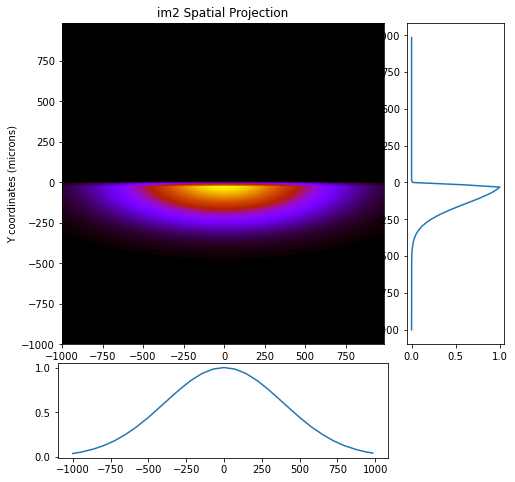

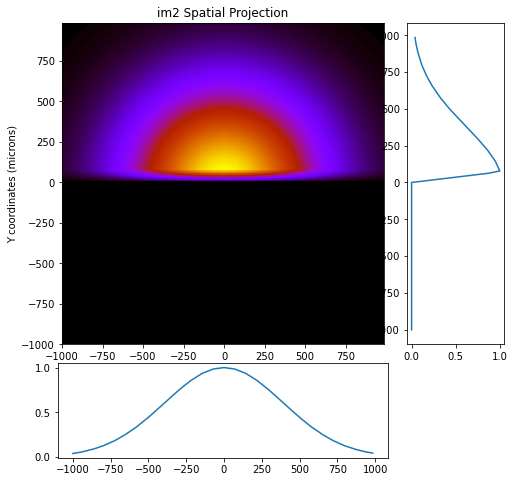

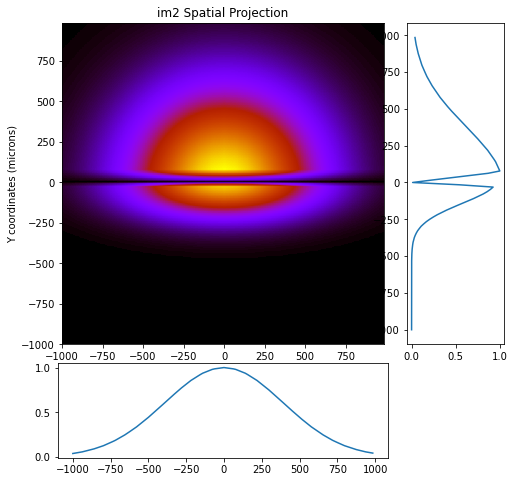

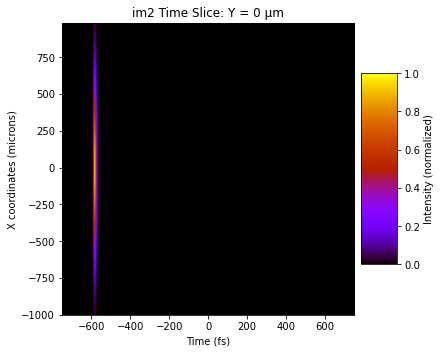

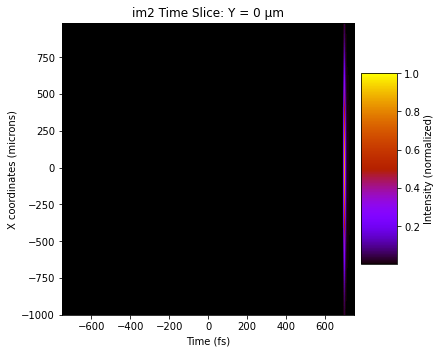

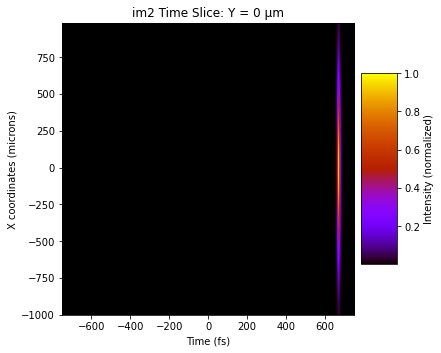

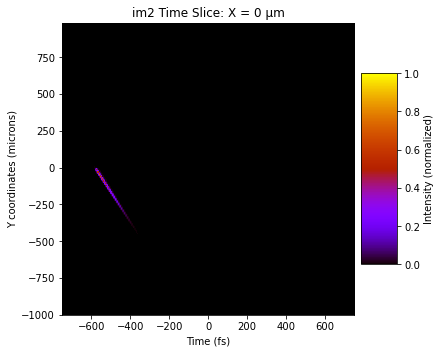

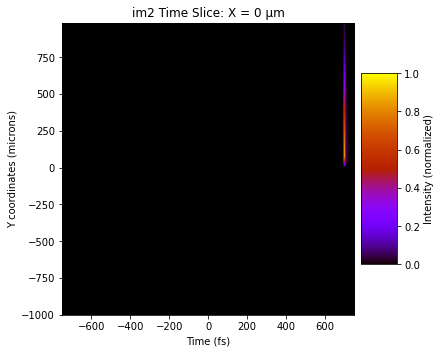

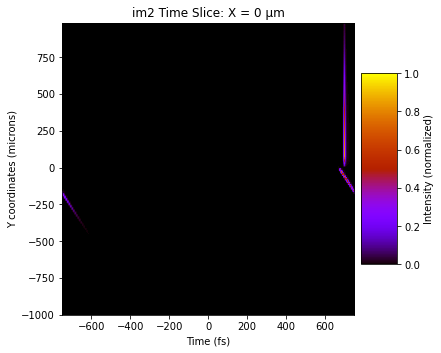

In [9]:
''' beam profiles after monochromator '''
im_name = 'im2'
part_name = 'mono'
pulse_VCC.imshow_projection(im_name)
plt.savefig(fig_path+'profile_VCC_{}.png'.format(part_name))
pulse_CC.imshow_projection(im_name)
plt.savefig(fig_path+'profile_VCC_{}.png'.format(part_name))
pulse_sum.imshow_projection(im_name)
plt.savefig(fig_path+'profile_Sum_{}.png'.format(part_name))

dim = 'x'
pulse_VCC.imshow_time_slice(im_name,dim=dim)
plt.savefig(fig_path+'tilt_{}_VCC_{}.png'.format(dim,part_name))
pulse_CC.imshow_time_slice(im_name,dim=dim)
plt.savefig(fig_path+'tilt_{}_CC_{}.png'.format(dim,part_name))
pulse_sum.imshow_time_slice(im_name,dim=dim)
plt.savefig(fig_path+'tilt_{}_Sum_{}.png'.format(dim,part_name))

dim = 'y'
pulse_VCC.imshow_time_slice(im_name,dim=dim)
plt.savefig(fig_path+'tilt_{}_VCC_{}.png'.format(dim,part_name))
pulse_CC.imshow_time_slice(im_name,dim=dim)
plt.savefig(fig_path+'tilt_{}_CC_{}.png'.format(dim,part_name))
pulse_sum.imshow_time_slice(im_name,dim=dim)
plt.savefig(fig_path+'tilt_{}_Sum_{}.png'.format(dim,part_name))


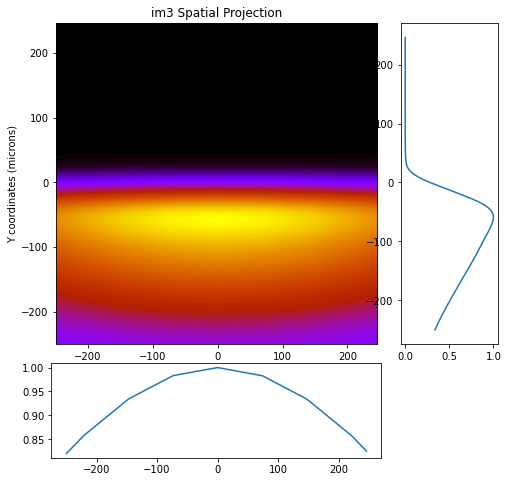

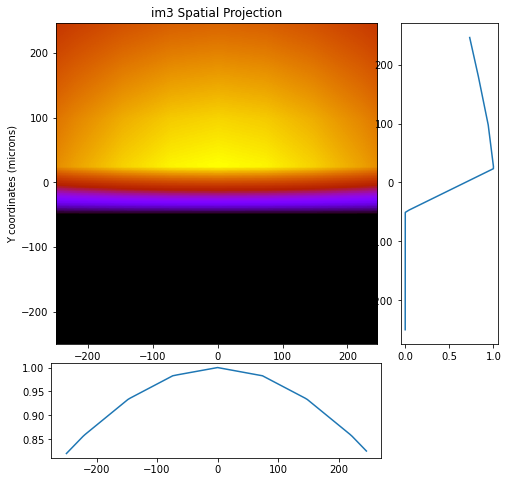

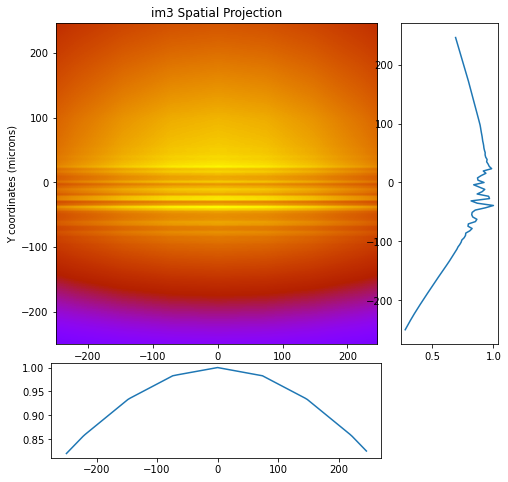

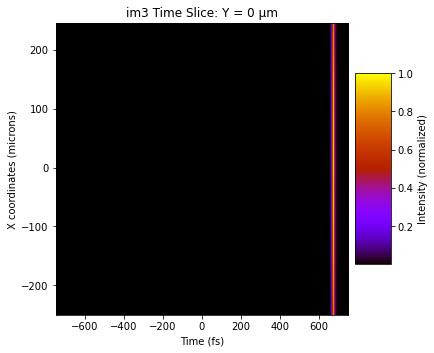

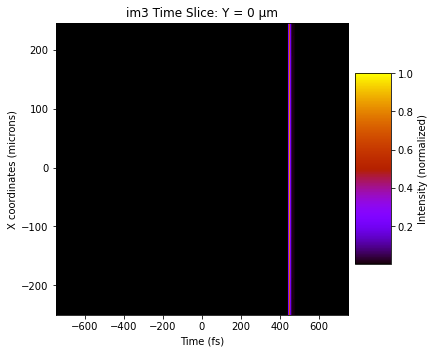

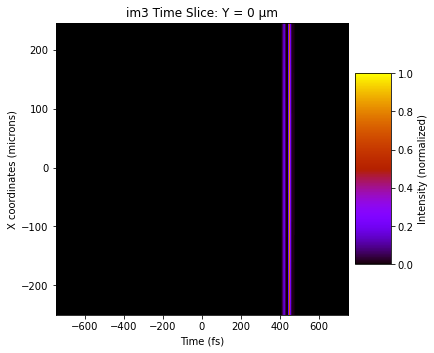

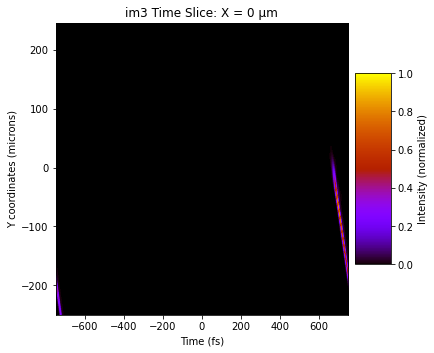

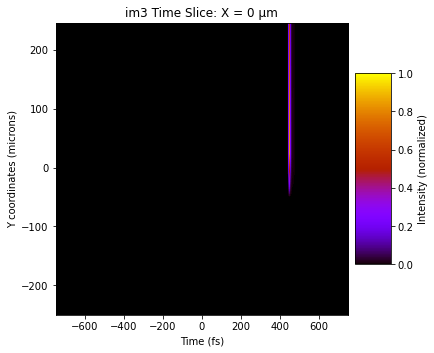

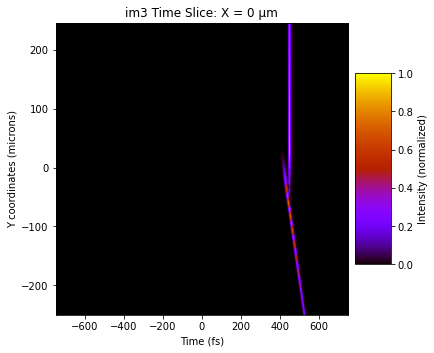

In [10]:
''' beam profiles after prism '''
im_name = 'im3'
part_name = 'prism'
pulse_VCC.imshow_projection(im_name)
plt.savefig(fig_path+'profile_VCC_{}.png'.format(part_name))
pulse_CC.imshow_projection(im_name)
plt.savefig(fig_path+'profile_VCC_{}.png'.format(part_name))
pulse_sum.imshow_projection(im_name)
plt.savefig(fig_path+'profile_Sum_{}.png'.format(part_name))

dim = 'x'
pulse_VCC.imshow_time_slice(im_name,dim=dim)
plt.savefig(fig_path+'tilt_{}_VCC_{}.png'.format(dim,part_name))
pulse_CC.imshow_time_slice(im_name,dim=dim)
plt.savefig(fig_path+'tilt_{}_CC_{}.png'.format(dim,part_name))
pulse_sum.imshow_time_slice(im_name,dim=dim)
plt.savefig(fig_path+'tilt_{}_Sum_{}.png'.format(dim,part_name))

dim = 'y'
pulse_VCC.imshow_time_slice(im_name,dim=dim)
plt.savefig(fig_path+'tilt_{}_VCC_{}.png'.format(dim,part_name))
pulse_CC.imshow_time_slice(im_name,dim=dim)
plt.savefig(fig_path+'tilt_{}_CC_{}.png'.format(dim,part_name))
pulse_sum.imshow_time_slice(im_name,dim=dim)
plt.savefig(fig_path+'tilt_{}_Sum_{}.png'.format(dim,part_name))

In [11]:
import winsound
winsound.PlaySound("*", winsound.SND_ALIAS)
winsound.PlaySound("*", winsound.SND_ALIAS)
winsound.PlaySound("*", winsound.SND_ALIAS)

In [12]:
# vertically go through an asymmetric crystal, b>1; then add a crl lens so both branches go through a spectrometer, plot spectrum (E vs t) to see if they overlap.
# if not, add a prism in one branch so that the spectrums overlaps. once overlapped, add both branches together.
# can make a branch tilt more so that not fringe everywhere.

# 1. no energy chirp (straight fringe)
# 2. only energy chirp (tilting fringe)

# the above two for proposal, see their difference

# 3. energy and spatial chirp ()